In [60]:
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml

from data_loader import get_dataloaders
from model import SRCNN
from test import evaluate_model
from utils import load_config, parse_args
import logging


In [61]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import numpy as np

In [62]:
resample_scale_factor = 2
num_epochs = 20
filename = "test_metrics.csv"

In [63]:
config = load_config("config.json")

In [ ]:
model_qualifier = "4xbutterfly"

In [81]:
model_folder = "modelButterflyScale4"

In [64]:
_, _, testloader = get_dataloaders(seed=42, resample_scale_factor=resample_scale_factor)

2025-02-26 16:13:39,138 - INFO - Using 22 images from ../data/train2017
2025-02-26 16:13:39,139 - INFO - Train dataset size: 18
2025-02-26 16:13:39,139 - INFO - Validation dataset size: 2
2025-02-26 16:13:39,140 - INFO - Test dataset size: 2


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = f"test_metrics_{model_qualifier}.csv"
for i in range(1,num_epochs+1):
    model = SRCNN()
    #if file exists
    if not os.path.isfile(f'../{model_folder}/model_{i}_final.pt'):
        print("File not found!")
        continue
    model.load_state_dict(torch.load(f'../{model_folder}/model_{i}_final.pt', map_location=device))
    evaluate_model(model, testloader, config, filename)

100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


In [66]:
def validate_model(model, validloader, criterion, device, config):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss

    avg_loss = total_loss / len(validloader.dataset)
    logging.info(f"Validation Loss: {avg_loss:.4f}")

    validation_metrics = evaluate_model(model, validloader, config)
    logging.info(validation_metrics)
    return validation_metrics

In [76]:
metric_file = f"../results/test_metrics_{model_qualifier}.csv"

In [77]:
loss_values = np.loadtxt("../modelOriginal/losses.csv", delimiter=",", usecols=0)
print(loss_values)

psnr_values = np.loadtxt(metric_file, usecols=1, skiprows=1, delimiter=",")
print(psnr_values)

ssim_values = np.loadtxt(metric_file, usecols=2, skiprows=1, delimiter=",")
print(ssim_values)

msssim_values = np.loadtxt(metric_file, usecols=3, skiprows=1, delimiter=",")
print(ssim_values)

[0.64535302 0.59264433 0.56473786 ... 0.00144396 0.00119906 0.00106422]
[26.8414 28.0176 28.673  28.9705 29.1296 29.1763 29.3099 29.4406 29.5032
 29.5394 29.5891 29.638  29.6497 29.7048 28.4897 29.7512 29.7648 29.801
 29.8426 29.8651 29.8897 29.8954 29.8854 29.9538 29.9721 29.9919 30.0408
 30.0585 30.0868 29.9472 30.1117 30.1456 30.174  30.1434 30.1676 30.2604
 30.2464 30.3008 30.3259 30.3477 30.2925 30.3729 30.1778 30.3802 30.414
 30.1802 30.4266 30.4313 30.4247 30.4546 30.438  30.4674 30.3729 30.458
 30.5287 30.54   30.5287 30.5616 30.5757 30.4975 30.6076 30.6287 30.6209
 30.6159 30.6728 30.6768 30.5092 30.3997 30.6828 30.6776 30.6249 30.7108
 30.709  30.7296 30.7208 30.6661 30.7573 30.6278 30.7471 30.7503 30.6828
 30.7437 30.7807 30.7359 30.7518 30.7524 30.7532 30.6851 30.7675 30.674
 30.7797 30.4804 30.7502 30.7482 30.8008 30.7777 30.7822 30.8199 30.7358
 30.8352]
[0.8748 0.9071 0.9182 0.923  0.926  0.9272 0.929  0.9305 0.9316 0.9324
 0.9332 0.934  0.9348 0.9352 0.9343 0.9361 0.936

In [78]:
num_epochs = len(loss_values) #// 296
loss_x = np.arange(0, num_epochs + 1, 1 / 296)
loss_x = loss_x[:len(loss_values)]

num_epochs = len(psnr_values) 
psnr_x = np.arange(0, num_epochs + 1, 1 )
psnr_x = psnr_x[:len(psnr_values)]

num_epochs = len(ssim_values)
ssim_x = np.arange(0, num_epochs + 1, 1 )
ssim_x = ssim_x[:len(ssim_values)]

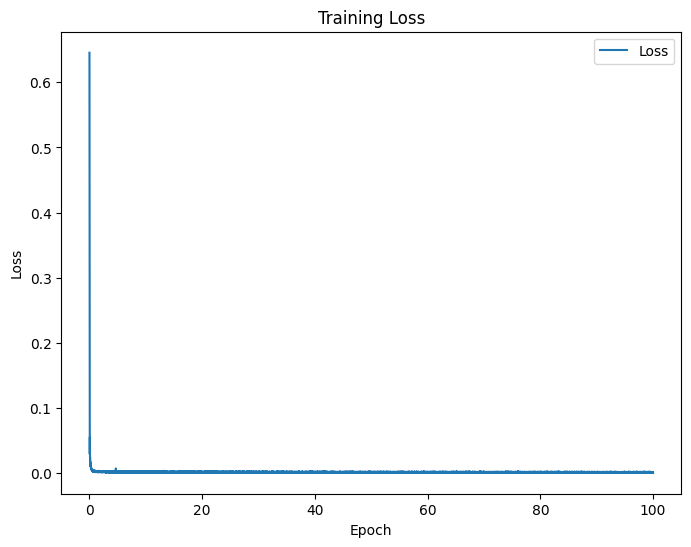

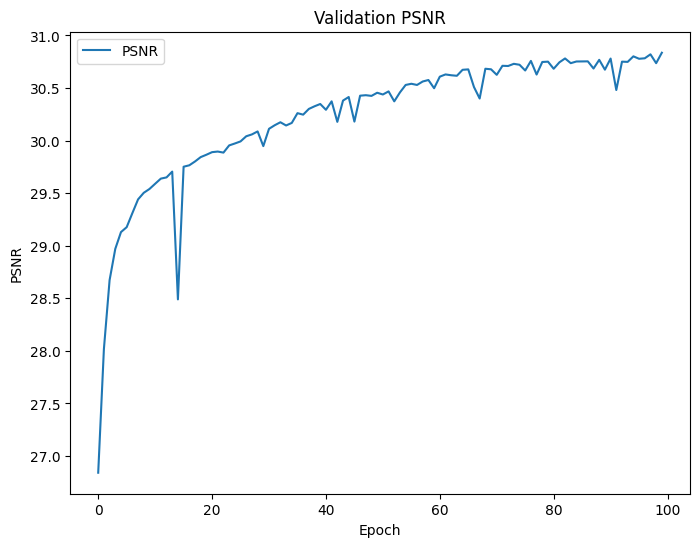

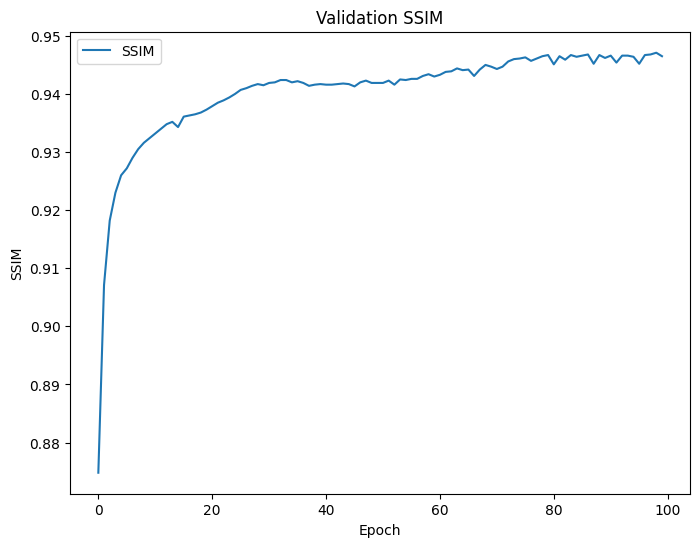

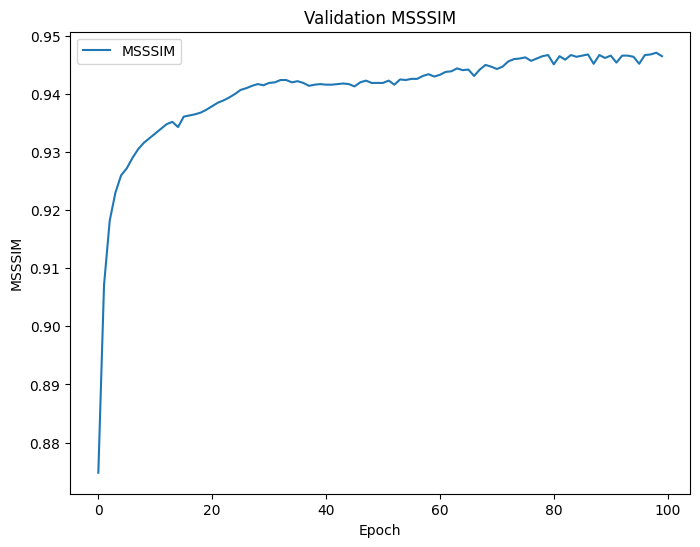

In [ ]:
# Plot the loss values
plt.figure(figsize=(8, 6))
plt.plot(loss_x, loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig(f'../results/training_loss_{model_qualifier}.png')
plt.show()

# Plot the PSNR values
plt.figure(figsize=(8, 6))
plt.plot(psnr_x, psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('Validation PSNR')
plt.legend()
plt.savefig(f'../results/validation_psnr_{model_qualifier}.png')
plt.show()

# Plot the SSIM values
plt.figure(figsize=(8, 6))
plt.plot(ssim_x, ssim_values, label='SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.legend()
plt.savefig(f'../results/validation_ssim_{model_qualifier}.png')
plt.show()


# Plot the MSSSIM values
plt.figure(figsize=(8, 6))
plt.plot(ssim_x, ssim_values, label='MSSSIM')
plt.xlabel('Epoch')
plt.ylabel('MSSSIM')
plt.title('Validation MSSSIM')
plt.legend()
plt.savefig(f'../results/validation_mssim_{model_qualifier}.png')
plt.show()